In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [29]:
number_of_samples = 3500
#input_signals = pd.read_csv('input_lc.csv', chunksize = number_of_samples)
output_signals = pd.read_csv('output_lc.csv', chunksize = number_of_samples)

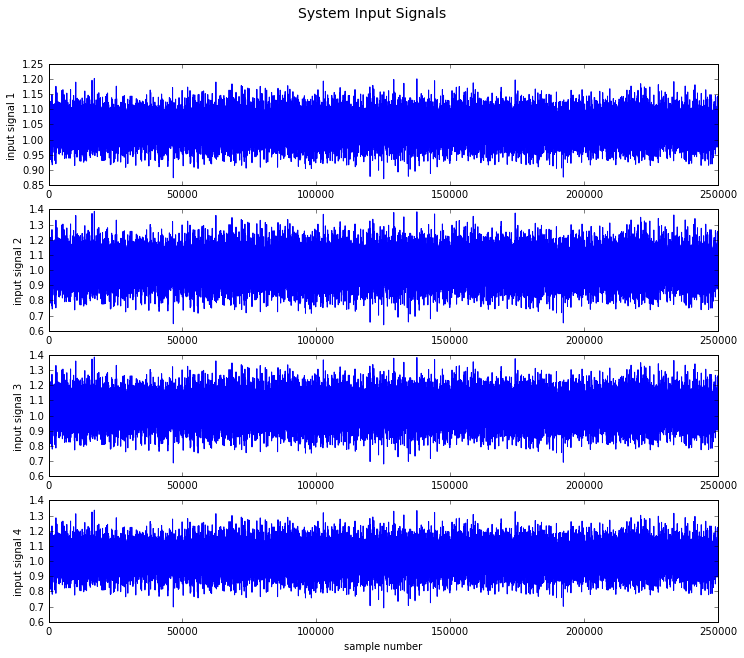

In [9]:
U = input_signals.get_chunk().as_matrix()
plt.figure(1, figsize=(12, 10)).suptitle('System Input Signals', fontsize=14)

for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(U[:,i])
    plt.ylabel('input signal {}'.format(i+1))
    
plt.xlabel('sample number')


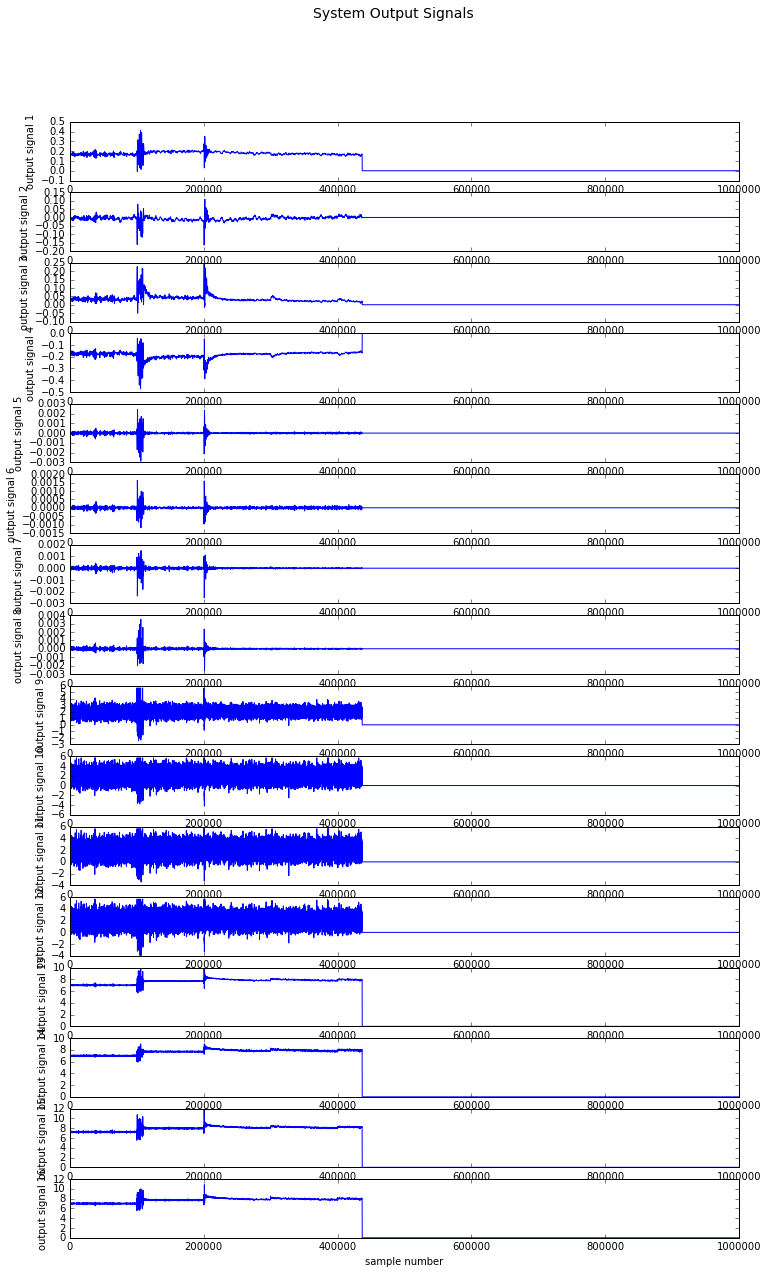

In [30]:
Y = output_signals.get_chunk().as_matrix()
plt.figure(1, figsize=(12, 20)).suptitle('System Output Signals', fontsize=14)
for i in range(16):
    plt.subplot(16,1,i+1)
    plt.plot(Y[:,i])
    plt.ylabel('output signal {}'.format(i+1))
    
plt.xlabel('sample number')


In [199]:
number_of_samples = 500
#input_signals = pd.read_csv('input_lc.csv', chunksize = number_of_samples)
output_signals = pd.read_csv('data.csv',header=None, chunksize = number_of_samples)
load_data = pd.read_csv('load_data.csv',header=None).as_matrix()

n = 5 # System Order
k = 2*n # Row number of block Hankel matrix 

stability_measure = []
system_eigenvalues = []
i = 0

for Y in output_signals:
    Y = Y.as_matrix()
    
    # Estimation of System Matrix (A)
    A = system_matrix_estimator([],Y,n,k)  
    
    # Extraction of System Eigenvalues 
    eigenvalues_of_A, normalized_eigenvectors = np.linalg.eig(A)
    
    # Stability measure
    stability_measure.append(1-max(abs(eigenvalues_of_A)))
    system_eigenvalues.append(eigenvalues_of_A)
    
    i = i+1
    if not i%1:
        print('Processed {}% of data.'.format(100*i*number_of_samples/3500))
    
    

Processed 14.285714285714286% of data.
Processed 28.571428571428573% of data.
Processed 42.857142857142854% of data.
Processed 57.142857142857146% of data.
Processed 71.42857142857143% of data.
Processed 85.71428571428571% of data.
Processed 100.0% of data.


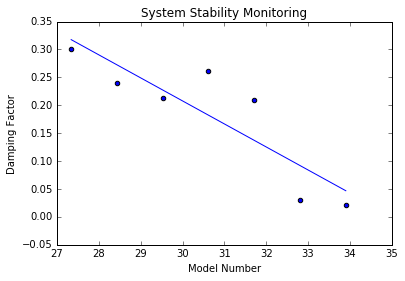

In [207]:
damping_factors = []
sampling_time = 0.01
for i in range(len(system_eigenvalues)):
    eigenvalues_of_continous_system = np.log(system_eigenvalues[i])/sampling_time  
    damping_factors.append(min(abs(eigenvalues_of_continous_system.real)/abs(eigenvalues_of_continous_system)))

x = load_data[:,1]
y = damping_factors
plt.scatter(load_data[:,1], damping_factors) # range(len(system_eigenvalues))
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x))
plt.ylabel('Damping Factor')
plt.xlabel('Model Number')
plt.title('System Stability Monitoring')
#plt.axis([0, 20, -0.01, 0.02])

In [178]:
len(load_data)
#len(damping_factors)

7

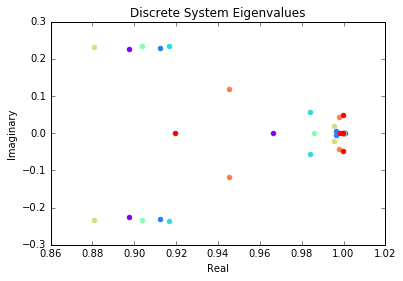

In [190]:
import matplotlib.cm as cm
colors = iter(cm.rainbow(np.linspace(0, 1, len(system_eigenvalues))))
for i in range(len(system_eigenvalues)):
    plt.scatter(system_eigenvalues[i].real,system_eigenvalues[i].imag, color=next(colors))
    
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('Discrete System Eigenvalues')
#plt.axis([0.99, 1, -0.01, 0.01])


[-2, 0, -8, 8]

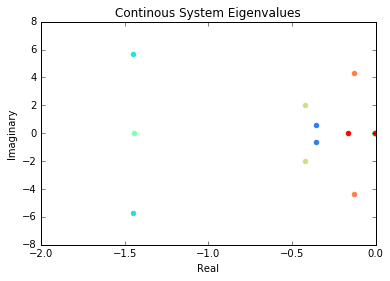

In [191]:
sampling_time = 0.01
colors = iter(cm.rainbow(np.linspace(0, 1, len(system_eigenvalues))))
for i in range(len(system_eigenvalues)):
    eigenvalues_of_continous_system = np.log(system_eigenvalues[i])/sampling_time   

    plt.scatter(eigenvalues_of_continous_system.real,
                eigenvalues_of_continous_system.imag, color=next(colors))
    
plt.ylabel('Imaginary')
plt.xlabel('Real')
plt.title('Continous System Eigenvalues')
plt.axis([-2, 0, -8, 8])


In [50]:
min(-eigenvalues_of_continous_system.real/np.absolute(eigenvalues_of_continous_system))


nan

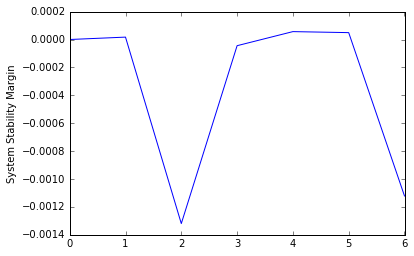

In [105]:
plt.plot(stability_measure)
plt.ylabel('System Stability Margin')
plt.show()

In [37]:
if not U:
    N =  np.rint(len(Y)/2)
    U = Y[:N,:]
    Y = Y[N:,:]

ndat,ny = Y.shape # ndat => Number of samples, ny => Number of system outputs
mdat,nu = U.shape # mdat => Number of samples, nu => Number of system inputs
if not ndat==mdat:
    print('MOESP Error: Number of input and output samples is not equal.')

1


In [41]:
np.rint(len(Y)/3)

16667.0

In [198]:
-

In [5]:
def blkhankel(X,i,j):
    #Make a block Hankel matrix with the data X containing l*i rows and j columns
#X = Y
#i = 100
#j = 5

    try:
        l, nd = X.shape
        if nd<l: 
            X = X.T
            l,nd = X.shape
    except:
        X = X.reshape(1,X.shape[0])
        nd = X.shape[1]
        l = 1

    if i < 0:
        print('blkHankel Error: Number of Hankel matrix rows (i) should be positive!!')
        return 

    if j < 0:
        print('blkHankel Error: Number of Hankel matrix columns (j) should be positive!!')
        return
    
    if j > nd-i+1:
        print('blkHankel Error: Number of Hankel matrix columns (j) is too big!!')
        return

    H = np.array([]).reshape(0,j)
    for k in range(i):
        H = np.concatenate((H, X[:,k:k+j]), axis=0)
    return H

In [ ]:
k = 100
n = 4


ndat,ny = Y.shape
mdat,nu = U.shape
if not ndat==mdat:
    print('MOESP Erroe: Number of input and output samples is not equal.')

N = ndat-k;
Uh = blkhankel(U,k,N);
Yh = blkhankel(Y,k,N);
H = np.concatenate((Uh,Yh), axis=0)/np.sqrt(N);

q, r = np.linalg.qr(H.T)
R = np.triu(r).T
R = R[:k*(ny+nu),:]

R22 = R[k*nu:,k*nu:]
Us,s,Vs = np.linalg.svd(R22)

Ok = np.dot(Us[:,:n],np.diag(np.sqrt(s[:n])))
A, residuals, rank, singular_values  = np.linalg.lstsq(Ok[:ny*(k-1),:], Ok[ny:k*ny,:])
eigenvalues_of_A, normalized_eigenvectors = np.linalg.eig(A)
#A = np.dot(np.linalg.pinv(Ok[]),)
#Ok = U1(:,1:n)*diag(sqrt(ss(1:n)));

#A=Ok(1:ny*(k-1),:)\Ok(ny+1:k*ny,:);
eigenvalues_of_A

In [ ]:
eigenvalues_of_A

In [ ]:
1-max(np.absolute(eigenvalues_of_A))

In [68]:
np.angle(eigenvalues_of_A, deg=1)

array([ 0.        ,  0.19017851, -0.19017851])

In [46]:
b = np.arange(6).reshape((3,2))
b = 

array([[0, 1],
       [2, 3],
       [4, 5]])

In [50]:
np.dot(a,b)

array([[10, 13],
       [28, 40],
       [46, 67]])